In [1]:
from keras.applications import VGG16
from keras.preprocessing import image
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.utils import np_utils
import matplotlib.pyplot as plt
plt.viridis()

/home/joshuah/venv3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/home/joshuah/venv3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/joshuah/venv3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Let's first create and train an MNIST classification model.

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255


Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [3]:
model = Sequential()
model.add(Conv2D(filters = 32,kernel_size=(3, 3), 
                 activation='relu', strides=(1, 1), 
                 padding='valid',
                 input_shape=(28,28,1)))
model.add(Conv2D(filters = 32,kernel_size=(3, 3), 
                 activation='relu', strides=(1, 1), 
                 padding='valid'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


In [4]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [5]:
model_training = model.fit(X_train, Y_train,
          epochs=15,
          batch_size=128,
         verbose = 0)

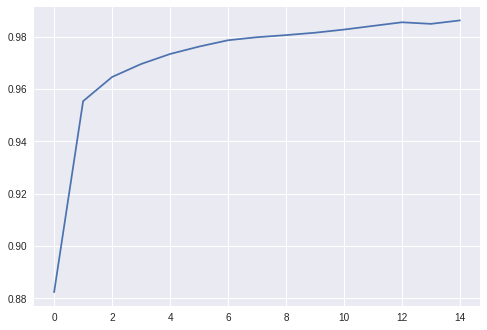

In [7]:
plt.plot(model_training.history["acc"])

Now that we have a trained model (that is fairly accurate), let's examine why and how the model makes classification decisions. 

##1. **Visualizing Activations **

The first thing we can do is input a particular image, and then visualize the feature maps in various portions of the network. This will tell us what parts of image were contributing to high activations for that feature map.

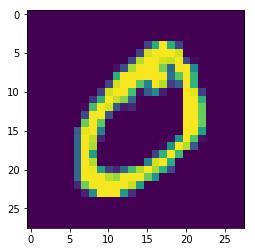

In [6]:
# sample image
plt.imshow(X_train[1,:].reshape((28,28)))
plt.grid(False)

In [7]:
from keras import models

def get_activations(image, model):
    layer_outputs = [layer.output for layer in model.layers]
    activations = models.Model(inputs=model.input, outputs=layer_outputs).predict(image)
    return activations

In [8]:
activations = get_activations( np.expand_dims( X_train[1,:], axis=0) , model)

In [9]:
first_layer_activations = activations[0]
second_layer_activations = activations[1]
pooling_layer_activations = activations[2]

In [10]:
first_layer_activations.shape

(1, 26, 26, 32)

In [11]:
second_layer_activations.shape

(1, 24, 24, 32)

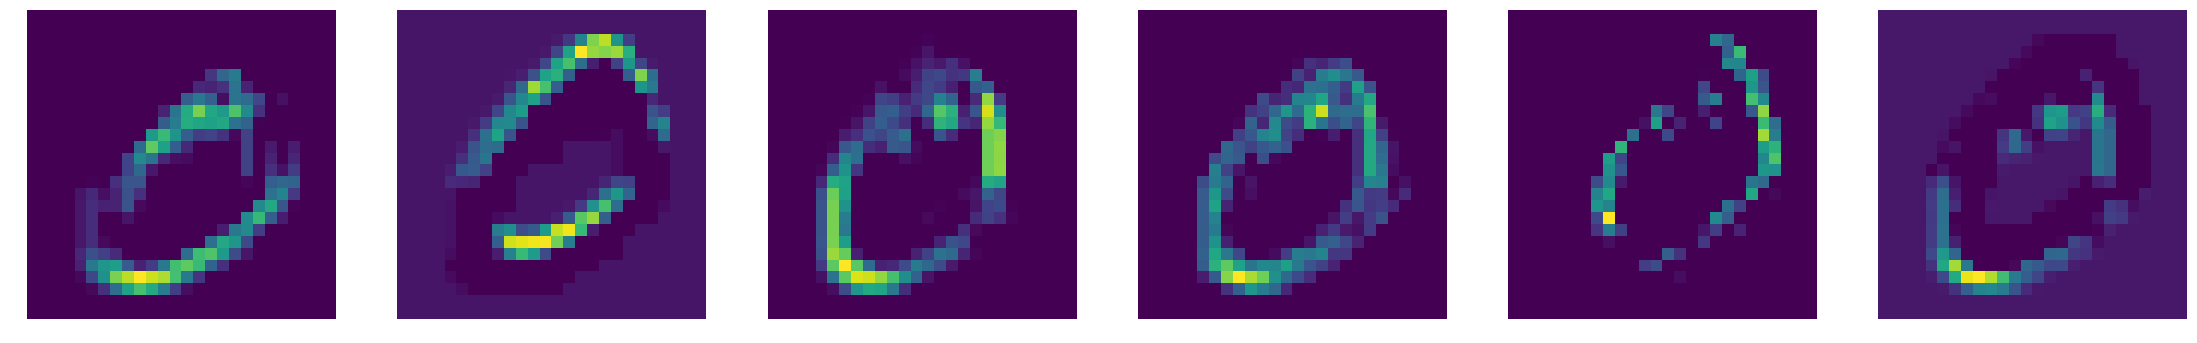

In [31]:
# Plotting the activations for the set of kernels
plt.figure(figsize=(30, 30))

for kernel_num in range(0,6):
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.subplot(6, 6, kernel_num + 1)
    plt.axis("off")
    plt.imshow(first_layer_activations[0,:,:,kernel_num])

The kernels in the first convolutional layer tend to be edge detectors of various types. Note that almost all the kernels are fairly highly activated for at least some portion of every image. And note that each kernel tends to activate in reponse to different part of the image.

Let's look at the next convolutional layer.

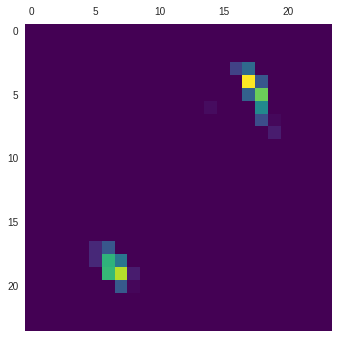

In [24]:
kernel_num=4
plt.matshow(second_layer_activations[0,:,:,kernel_num])
plt.grid(False)

In [ ]:
# Plotting the activations for the set of kernels
plt.figure(figsize=(30, 30))

for kernel_num in range(0,32):
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.subplot(6, 6, kernel_num + 1)
    plt.axis("off")
    plt.imshow(second_layer_activations[0,:,:,kernel_num])

Note that these activations are a bit more sparse - only small subsets of the input image seems to activating these kernels. 

### Let's look at the pooling layer.

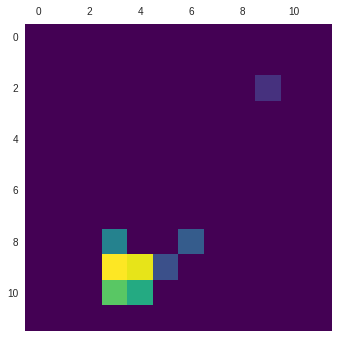

In [25]:
kernel_num=5
plt.matshow(pooling_layer_activations[0,:,:,kernel_num])
plt.grid(False)

In [ ]:
# Plotting the activations for the set of kernels
plt.figure(figsize=(30, 30))

for kernel_num in range(0,6):
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.subplot(6, 6, kernel_num + 1)
    plt.axis("off")
    plt.imshow(pooling_layer_activations[0,:,:,kernel_num])

Again, these feature maps are more abstract and less related to the actual image. We are losing high spatial-resolution, and instead overall features and concepts that are important for the classification task.

Let's visualize all the activaitons in these first three layers.

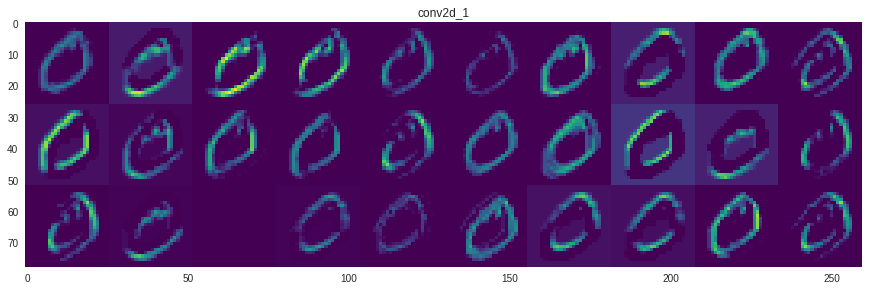

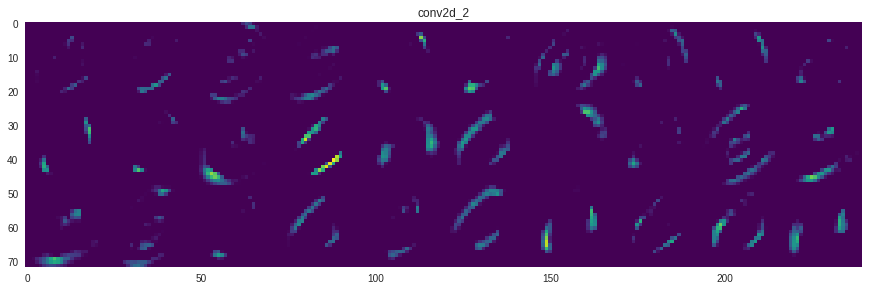

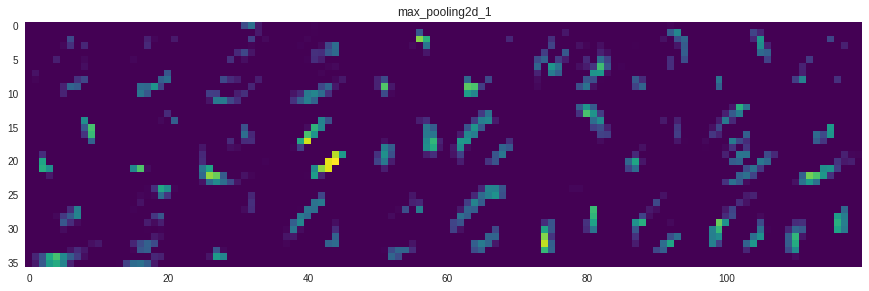

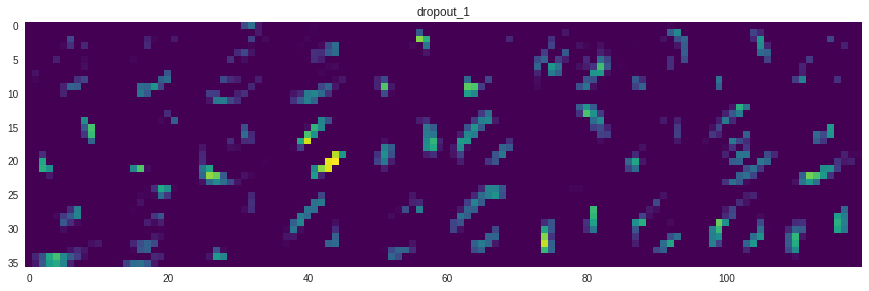

In [26]:
layer_names = []
for layer in model.layers[:4]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 10

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            #channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            #channel_image /= channel_image.std()
            #channel_image *= 64
            #channel_image += 128
            #channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1.5 / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto')



In summary - note that the early activations are simple concepts like edges and curves. The later activations are more abstracted - as they are combinations of the earlier feature maps. We also lose spatial resolution and locational information as we go along the convolutional stack - especially with pooling. After pooling, even notice that some of the kernels are completely silent for this particular image. Thus, these representations are more "sparse" - the activations that are silent for this image are presumably tuned to entirely different kinds of images from the training data.

#2. Visualizing a Kernel's Preferences

Another way to explore CNNs is to visualize what kinds of images a particular kernel is tuned to activate highly for. A simple way to do this is to iterate over the whole dataset and find the top several images that lead to high activation of a kernel. This is a simple enough process and can be quite informative, but we will skip it for now.

Another approach is synethically generate a new image that maximally activates a particular kernel. How can we do this? 

We will start with a randomized images (jusy noisy pixels) and use Gradient Descent to alter the pixels in the direction which increases the activation of our chosen kernel. After we have optimized this new kind of Cost function, the result with be an image that best represents what the chosen kernel is "looking for".

To do this, we'll start with a pre-trained network that was trained on complex image datasets. 

In [32]:
from keras import backend as K

In [33]:
def process_image(tensor):
    tensor -= tensor.mean()
    tensor /= tensor.std() + 1e-5
    tensor *= 0.1

    tensor += 0.5
    tensor = np.clip(tensor, 0, 1)

    tensor *= 255
    x = np.clip(tensor, 0, 255).astype("uint8")
    return np.squeeze(x)

In [34]:
def create_kernel_pattern(model, 
                          layer_name="block3_conv1", 
                          kernel_num =2,
                          image_shape = (1, 150, 150, 3)):


    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,kernel_num])

    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    step = K.function([model.input], [loss, grads])
    loss_val, grads_val = step([np.zeros(image_shape)])

    input_img = np.random.random(image_shape) *20 + 128

    learning_rate = 1
    for i in range(100):
    loss_val, grads_val = step([input_img])
    input_img += grads_val * learning_rate

    return process_image(input_img)

In [37]:
from keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet', include_top=False)


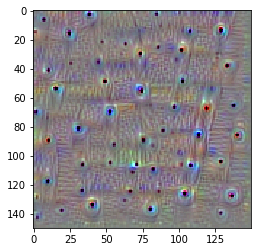

In [38]:
im = create_kernel_pattern(vgg_model, "block4_conv2",kernel_num=4)
plt.imshow(im)
plt.grid(False)

In [39]:
size = 150
margin = 5

image_grid = np.zeros((8*size + 7*margin, 8*size + 7*margin, 3))

for i in range(8):
    for j in range(8):
        pattern = create_kernel_pattern(vgg_model, "block4_conv2",kernel_num= i+ (j*8))

        hor_start = i * size + i* margin
        hor_end = hor_start + size
        vert_start = j*size + j*margin
        vert_end = vert_start + size

        image_grid[hor_start:hor_end, vert_start: vert_end, :] = pattern
  


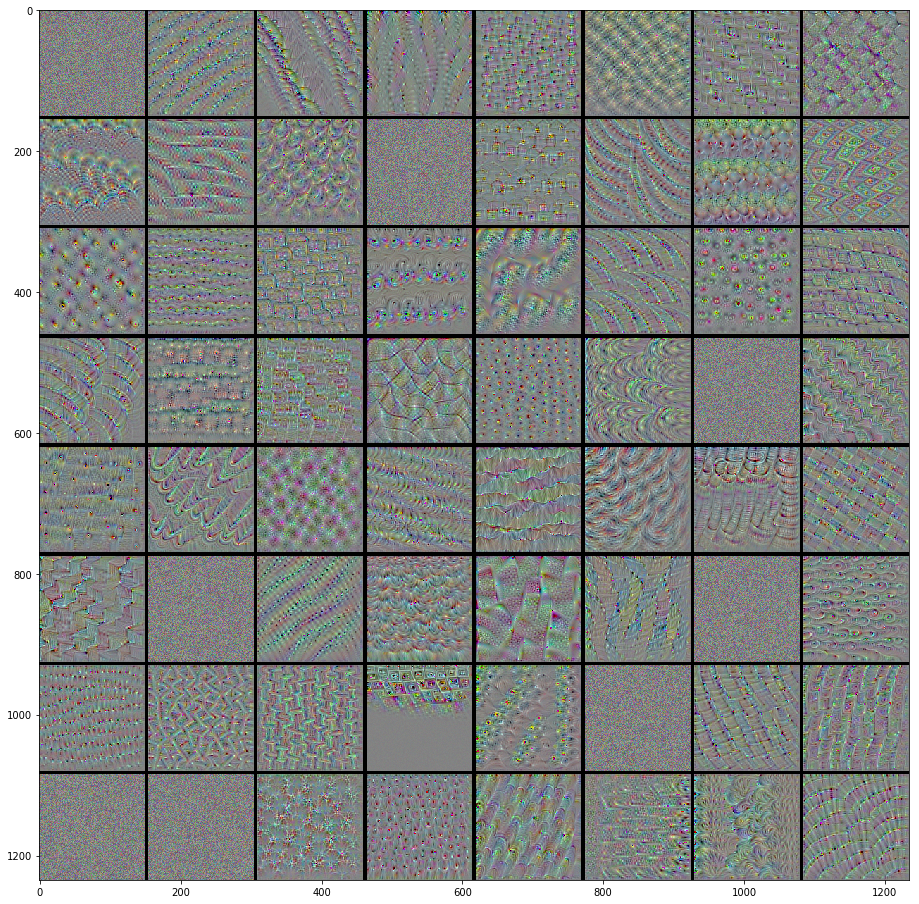

In [40]:
plt.figure(figsize=(16,16))
plt.imshow(image_grid)
plt.grid(False)

We can do the same thing with our MNIST model (though some of the kernels aren't as interesting).

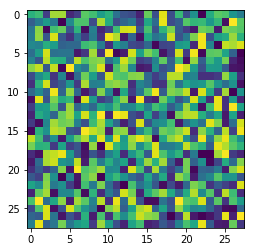

In [46]:
im = create_kernel_pattern(model, 
                           layer_name="conv2d_2",
                           kernel_num=5,
                          image_shape = (1, 28, 28, 1))
plt.imshow(im)
plt.grid(False)